In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import STL, seasonal_decompose

from statsmodels.tsa.forecasting.stl import STLForecast

A decomposição de uma serie temporal envolve estimar os seus componentes.

Para decompor uma série temporal e obter os componentes individuais dela, precisamos antender como iremos decompor a série, existem algumas formas.

Aditiva: $y_t = S_t + T_t + R_t$

Multiplicativa: $y_t = S_t \times T_t \times R_t$

Quando a série temporal variar ao longo da tendência é apropriado uma decomposição multiplicativa, caso contrario, quando a magnitude da serie não variar ao longo da tendencia ou a variação ao longo da tendencia não variavem com o nível da serie temporal para este caso é adequando a decomposição aditiva.

### 1.0. Moving Averages & Classical Decomposition

#### 1.1. Time Series Components

In [47]:
df = pd.read_csv('../data/us_employment.csv', index_col=[0])
df = df[df['Title'] == 'Retail Trade']

df['Month'] = pd.to_datetime(df['Month'], format='%Y %b')

df = df[df['Month'] >= '1990'].reset_index(drop=True)

In [20]:
df.head()

,Month,Series_ID,Title,Employed
0,1990-01-01,CEU4200000001,Retail Trade,13255.8
1,1990-02-01,CEU4200000001,Retail Trade,12966.3
2,1990-03-01,CEU4200000001,Retail Trade,12938.2
3,1990-04-01,CEU4200000001,Retail Trade,13012.3
4,1990-05-01,CEU4200000001,Retail Trade,13108.3


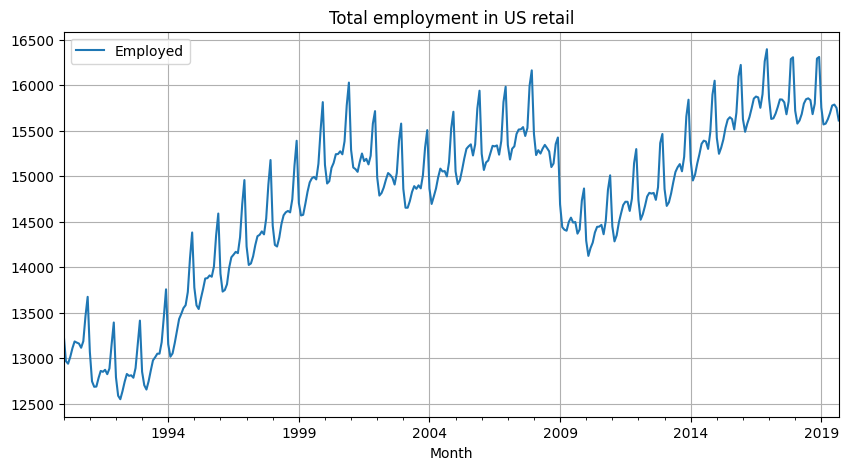

In [4]:
df.plot(x='Month', y='Employed', figsize=(10,5), grid=2, title="Total employment in US retail");

In [25]:
# Precisa setar o Index com a data caso for usar o STL.
# Existem muitos parametros q podem ser tunados com grid search para minimizar o Resid por exemplo.
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html


stl = STL(
    df.set_index("Month")["Employed"],
)

dcomp = stl.fit()

In [22]:
# Para pegar cada resultado, basta chamar o método
dcomp.resid.head()

Month
1990-01-01   -36.748889
1990-02-01   -21.386851
1990-03-01   -10.805048
1990-04-01    13.088750
1990-05-01     9.627836
Name: resid, dtype: float64

Observação: Cuidado com a Escala do eixo Y, em R ele automticamente plota uma barrinha ao lado para comprar a escala, em python infelizmente não tem isso :(

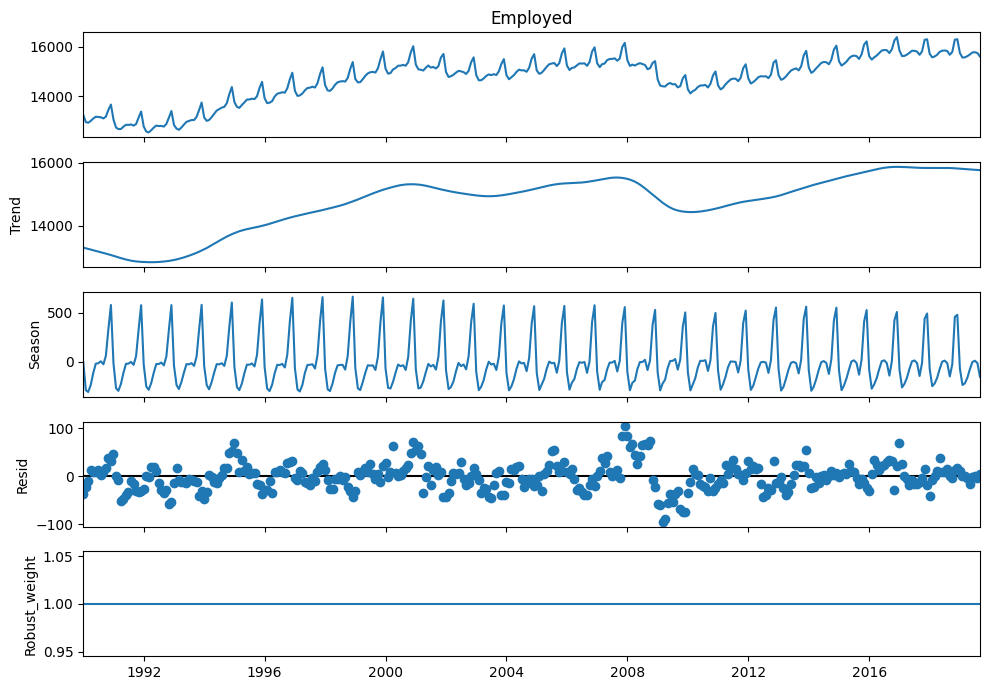

In [24]:
plt.rcParams['figure.figsize'] = [10, 7]
dcomp.plot(weights=True);

Se o componente sazonal for removido da série, isso é chamado de "seasonally adjusted data".

Esse tipo de análise tem como principal objetivo realçar ou indicar algum fenômeno que não tem nada a ver com a sazonalidade, o livro traz um exemplo de variação de taxa de desemprego levando em conta férias escolares (Isso é um fenômeno sazonal) contra a variação não sazonal.

In [37]:
df["season_adjust"] = (df["Employed"].values - dcomp.seasonal.values)

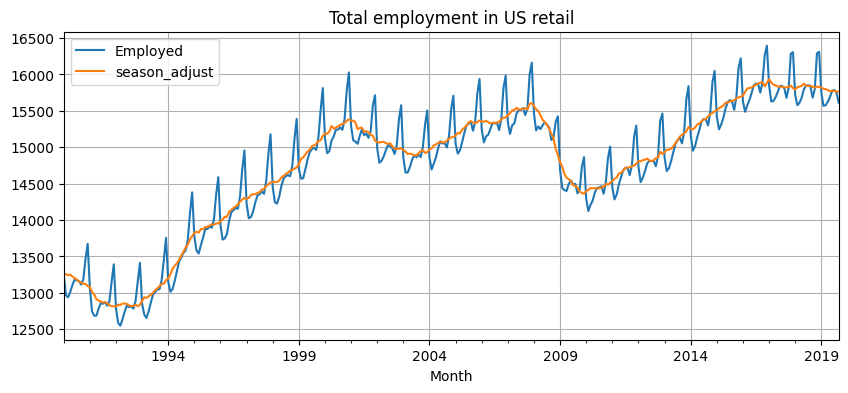

In [44]:
df[["Month", "Employed", "season_adjust"]].plot(
    x="Month", figsize=(10,4), grid=2, title="Total employment in US retail"
);

#### 1.2. Time Series Decomposition With Moving Averages

Agora precisamos entender como que iremos obter esses componentes.

No conceito de decomposição clássica, é utilizado as médias móveis para estimar a tendência.

$\hat{T_t} = \frac{1}{m} \times \sum_{j=-k}^{k} y_{t + j} $ onde $m = ordem$ e $k = \frac{(m - 1)}{2}$

Exemplo, m = 3

$k = \frac{(3 - 1)}{2} = 1, k = 1$

$\hat{T_t} = \frac{1}{3} \times \sum_{j=-1}^{1} y_{t+j}$

$\hat{T_t} = \frac{1}{3} * (y_{t-1} + y_{t} + y_{t+1})$

- Geralmente utilizamos uma ordem ímpar para nãos precisar fazer médias móveis de médias móveis.

No Pandas, existe o parâmetro center para o método rolling de uma Series, assim podemos empurrar a média movel para frente, com o center = False conseguimos obter quase os mesmos resultados do livro.

In [92]:
data = [1, 1, 1, 2, 2, 2, 3, 3, 3]

print(data)
print("="*27)
print("Tt1 = 1 / 3 * (yt-1 + yt + yt+1) = {:.4f}".format(1 / 3 * (1 + 1 + 1)))

pd.Series(data).rolling(window=3, center=True).mean()

[1, 1, 1, 2, 2, 2, 3, 3, 3]
Tt1 = 1 / 3 * (yt-1 + yt + yt+1) = 1.0000


0         NaN
1    1.000000
2    1.333333
3    1.666667
4    2.000000
5    2.333333
6    2.666667
7    3.000000
8         NaN
dtype: float64

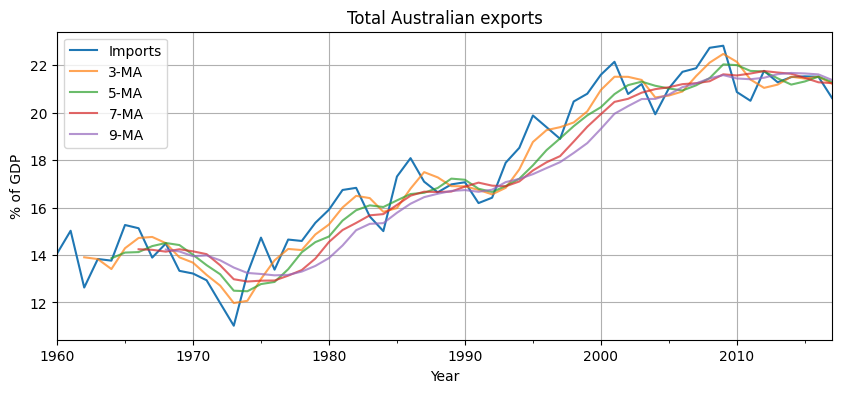

In [67]:
df = pd.read_csv("../data/global_economy.csv", index_col=[0])
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

df = df[df["Country"] == "Australia"]
df.reset_index(drop=True, inplace=True)

ax = df.plot(x="Year", y="Imports", figsize=(10, 4), title="Total Australian exports", ylabel="% of GDP");

for m in [3, 5, 7, 9]:
    df[f"{m}-MA"] = df["Imports"].rolling(window=m).mean()

    ax = df.plot(x="Year", y=f"{m}-MA", grid=2, alpha=.7, ax=ax)

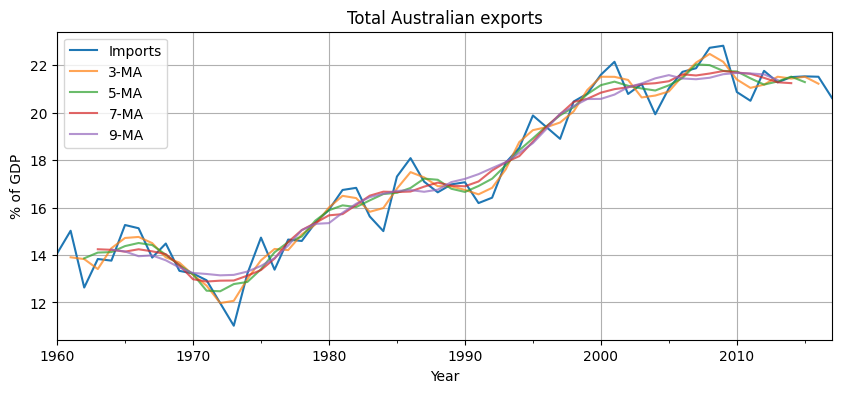

In [68]:
ax = df.plot(x="Year", y="Imports", figsize=(10, 4), title="Total Australian exports", ylabel="% of GDP");

for m in [3, 5, 7, 9]:
    df[f"{m}-MA"] = df["Imports"].rolling(window=m, center=True).mean()

    ax = df.plot(x="Year", y=f"{m}-MA", grid=2, alpha=.7, ax=ax)

In [3]:
df = pd.read_csv('../data/us_employment.csv', index_col=[0])
df = df[df['Title'] == 'Retail Trade']

df['Month'] = pd.to_datetime(df['Month'], format='%Y %b')

df = df[df['Month'] >= '1990'].reset_index(drop=True)

df["12-MA"] = df["Employed"].rolling(
    window=12,
    center=True
).mean()

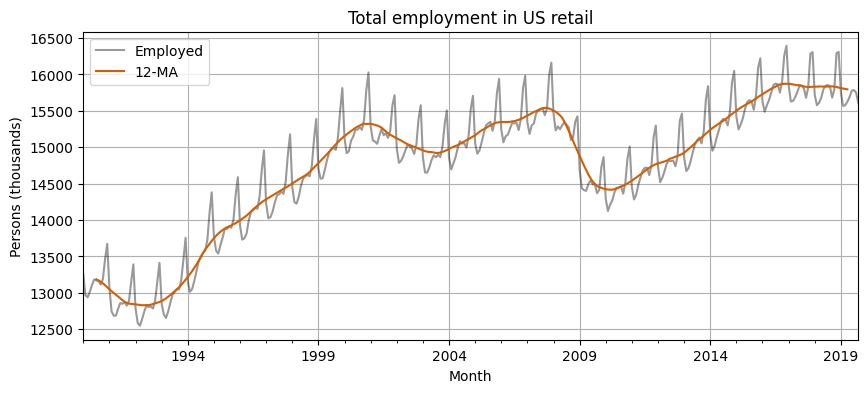

In [4]:
ax = df.plot(x="Month", y="Employed", figsize=(10, 4), color="k", alpha=.4)
ax = df.plot(
    x="Month", y="12-MA", grid=2, color="#D55E00",
    title="Total employment in US retail", ylabel="Persons (thousands)",
    ax=ax
);

Notas:

- Grandes ordem de m, mais suave vai ser a curva.
- Grandes ordens de m, mais pontos perdidos no começo e no final.
- Se a ordem m for igual a sazonalidade, a tendencia é que a sazonalidade seja removida.

#### 1.3. Classical Decomposition

Existem duas formas de fazer uma decomposição, a forma aditiva e a multiplicativa.

- Na decomposição clássica assumimos que o componente sazonal é constante de ano para ano, ou seja, a sazonalidade se repete.
- A decomposição é uma froma de selecionar modelos do tipo ETS. (Li isso em um artigo do Medium sobre modelos ETL).

Passo a Passo para calcular a decomposição clássica aditiva:

1. Calcular $\hat{T_t}$ usando MA.
2. Calcular a diferença entre $y_t - \hat{T_t}$, isso é chamado de $detendred~series$.
3. Calcular o componente sazonal, para isso, apenas calculamos a média da $detendred~series$ para cada "season", por exemplo, com dados mensais, calculamos a média da detrended para todos os meses de março no dataset, depois "ajustamos" esses dados para que a soma seja igual a zero, por fim, o componente sazonal é obtida agrupando estes valores mensais e depois replicando a sequência para cada ano de dados.
4. O componente restante é calculado apenas realizando essa difereça: $\hat{R_t} = e_t - \hat{T_t} - \hat{S_t}$.

Já para a decomposição multiplicativa, é a mesma coisa, exceto que em vez de fazer a diferença, é a divisão e também temm a nomenclatura do "Seasonal Index" que nada mais é que a sazonalidade.

1. Calcular $\hat{T_t}$ usando MA.
2. Calcular a diferença entre $y_t / \hat{T_t}$, isso é chamado de $detendred~series$.
3. Para calcular o $\hat{St}$, caso os dados sejam mensais como citado anteriormente, utilizamos cada mês e obtemos o "seasonal index" calculando a média "detrended" para cada valores de março, por fim a soma é ajustada para dar $m$.
4. Por fim, o restante, é calculado desta forma: $\hat{R_t} = y_t / (\hat{T_t} \times \hat{S_t})$.

In [5]:
df.head()

,Month,Series_ID,Title,Employed,12-MA
0,1990-01-01,CEU4200000001,Retail Trade,13255.8,NaN
1,1990-02-01,CEU4200000001,Retail Trade,12966.3,NaN
2,1990-03-01,CEU4200000001,Retail Trade,12938.2,NaN
3,1990-04-01,CEU4200000001,Retail Trade,13012.3,NaN
4,1990-05-01,CEU4200000001,Retail Trade,13108.3,NaN


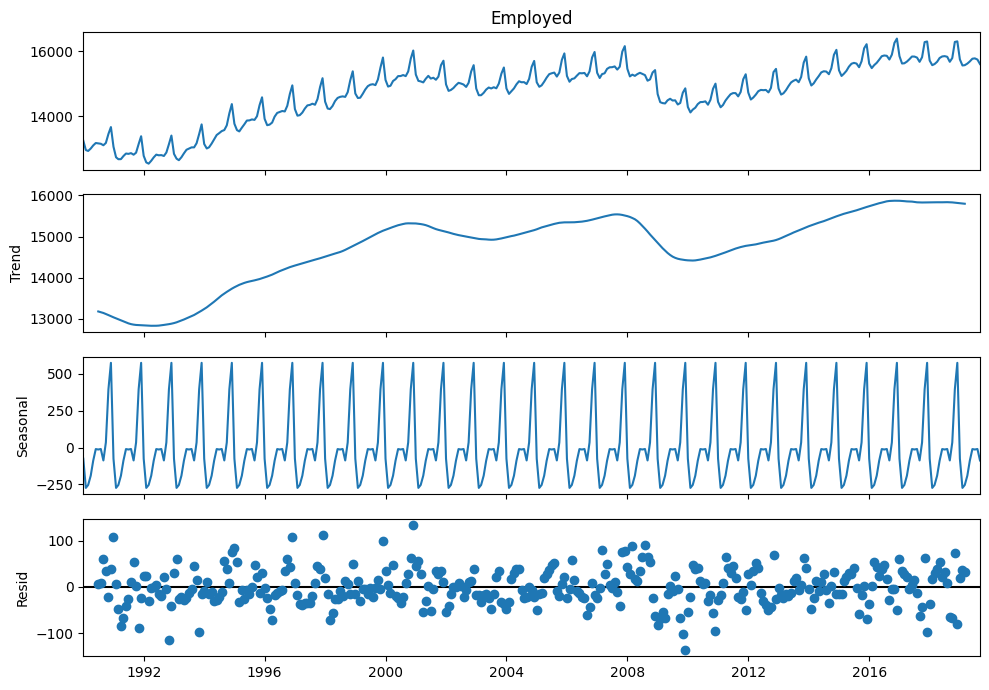

In [30]:
components = seasonal_decompose(
    df.set_index('Month')['Employed'],
    period=12,
    two_sided=True, # Moving Average centralizada
    model='additive', # Decomposição Aditiva
    extrapolate_trend=0,
)

plt.rcParams['figure.figsize'] = [10, 7]
components.plot();

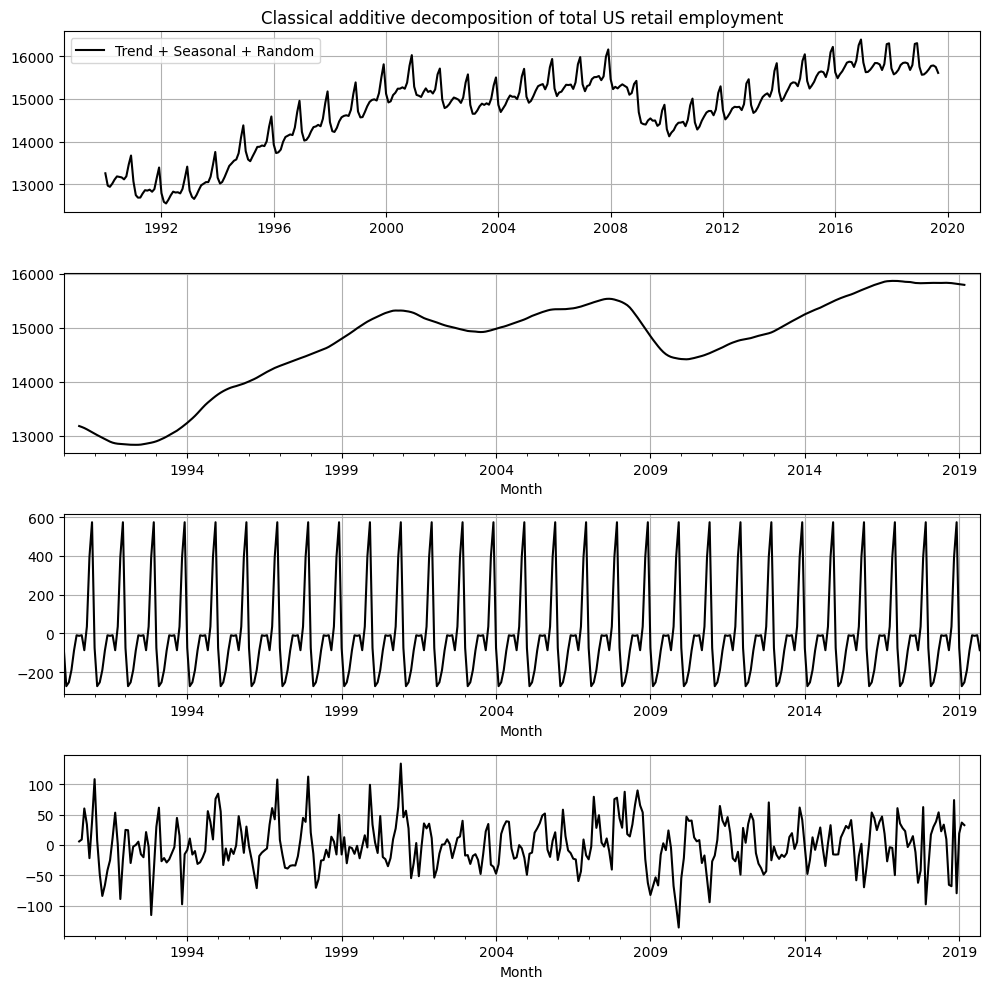

In [28]:
fig, ax = plt.subplots(4, 1, figsize=(10,10))

ax[0].plot(df["Month"], df["Employed"], color="k", label="Trend + Seasonal + Random")
ax[0].set_title("Classical additive decomposition of total US retail employment")
ax[0].legend()

components.trend.plot(ax=ax[1], color="k")
components.seasonal.plot(ax=ax[2], color="k")
components.resid.plot(ax=ax[3], color="k")

for axi in ax: axi.grid(2)

plt.tight_layout()

### 2.0. STL Decomposition

STL: "Seasonal and Trend decomposition using Loess" é uma ferramenta de decomposição robusta e versátil, corrige problemas da decomposição clássica e alguns outros problemas voltados a sazonalidade, com STL podemos endereçar outros tipos de sazonalidade.

Porem tem algumas limitações como, não poder ser utilizado com variáveis exogenas e so existe a versão aditiva, portanto temos que usar transformações como a box-cox ou log.

Talvez, por exemplo, pela implementação do Python por ter vários parâmetros eu teria que fazer um fine tuning a fim de encontrar os parâmetro que minimizam a soma dos residos.
Os residos parecem relativamente menores comparados com a solução clássica, entretando ele teve alguns residuos bem grandes proximos de 2009 que talvez no fine tuning eu consiga corrigir.

Notas:

- A suavidade do ciclo de tendência também pode ser controlada pelo usuário.
- Pode ser robusto para valores discrepantes, de modo que observações incomuns ocasionais não afetarão as estimativas do ciclo de tendência e dos componentes sazonais. Eles irão, no entanto, afetar o componente restante.

In [66]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html

stl = STL(
    df.set_index('Month')['Employed'], 
    robust=True, 
    period=12,   # Periodos Sazonais
    seasonal=11, # Smoothing
)

components = stl.fit()

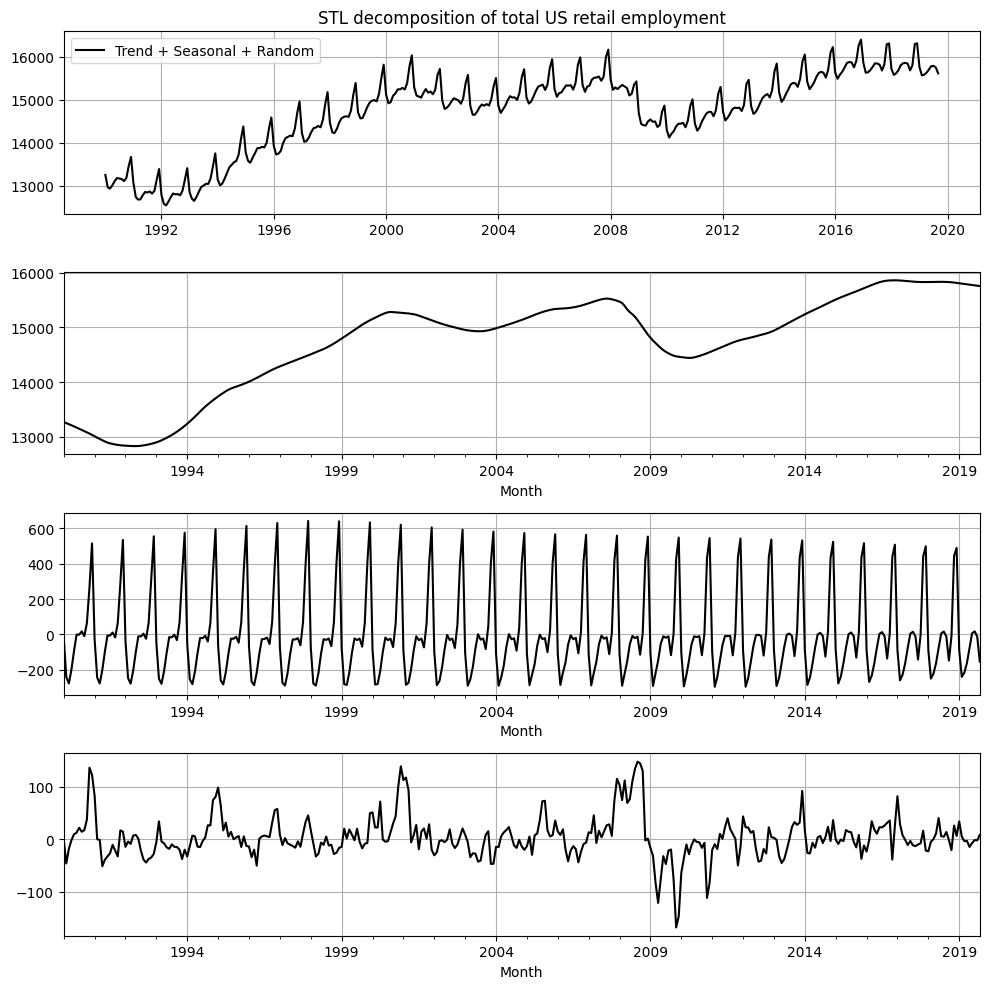

In [67]:
fig, ax = plt.subplots(4, 1, figsize=(10,10))

ax[0].plot(df["Month"], df["Employed"], color="k", label="Trend + Seasonal + Random")
ax[0].set_title("STL decomposition of total US retail employment")
ax[0].legend()

components.trend.plot(ax=ax[1], color="k")
components.seasonal.plot(ax=ax[2], color="k")
components.resid.plot(ax=ax[3], color="k")

for axi in ax: axi.grid(2)

plt.tight_layout()